# Overview

In [ ]:
pip install --upgrade tensorflow

Here we gonna use CNN-LSTM to predict the image content as a sentence where input will be a image. Here gonna use encoder_decoder network where CNN(AlexNet model) will be our encoder_network which will convert our image into a linear vector and then we have to pass that linear vector into a LSTM network(decoder_network) which will generate the text for that image.

In [ ]:
from IPython.display import Image

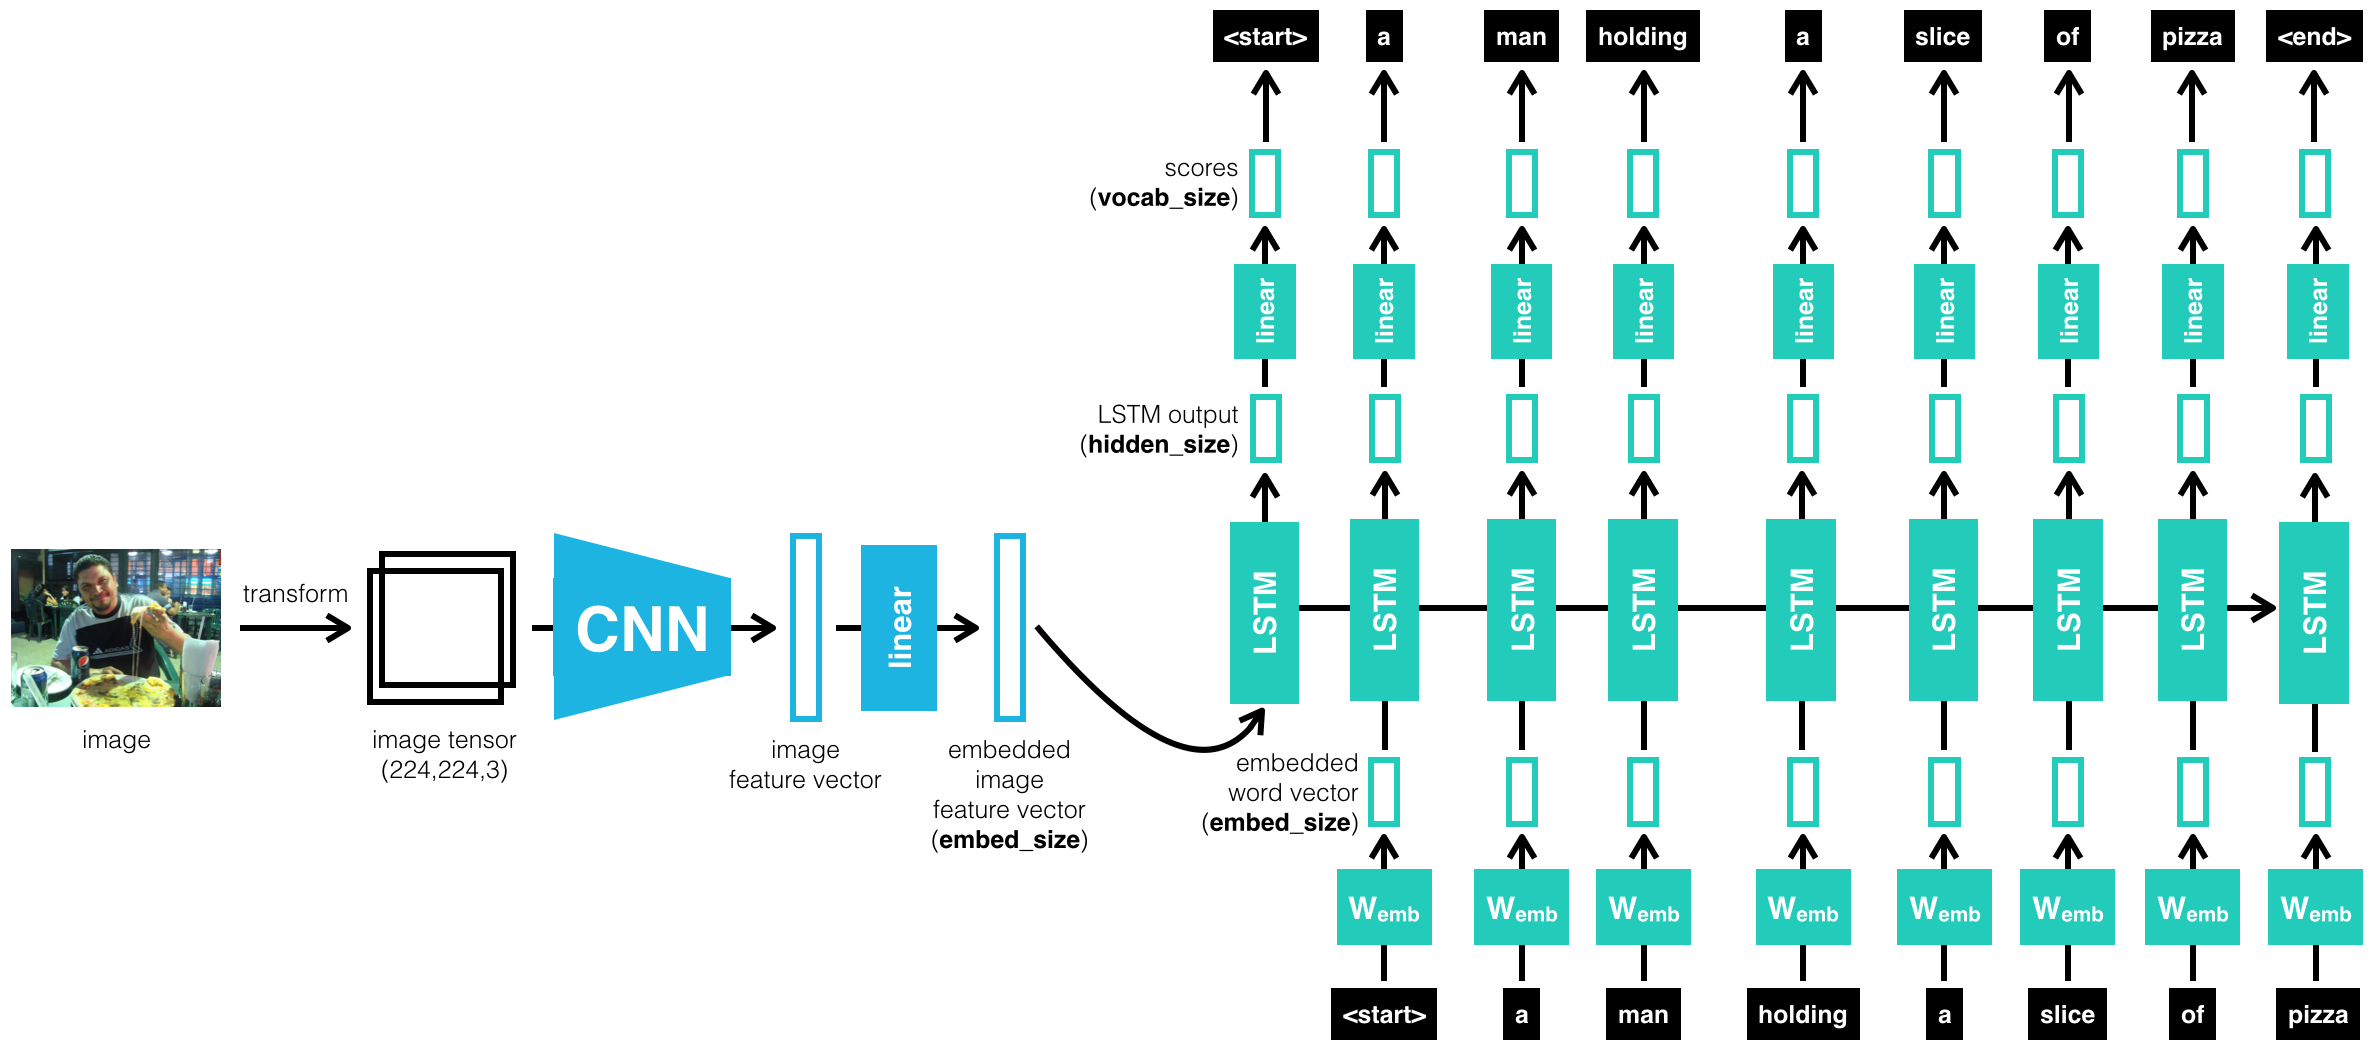

In [ ]:
#Image('/content/sample_data/encoder-decoder.png')

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing import image,sequence
import numpy as np
import pandas as pd
#from keras.applications.resnet50 import ResNet50
from keras.optimizers import adam_v2
from keras.layers import Dense,Conv2D,Concatenate,Flatten,Dropout,LSTM,Embedding,Bidirectional,Activation,Input,RepeatVector,TimeDistributed
from keras.models import Sequential,Model
import random
import matplotlib.pyplot as plt
import pickle as pkl
import os
import progressbar

# Data Downloading from Kaggle

In [ ]:
data_API_command = 'kaggle datasets download -d shadabhussain/flickr8k'

In [ ]:
os.getcwd()

'/content'

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"steveabhishek","key":"784b75b23b20db654f0ebdffe71d14c1"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

 99% 2.11G/2.13G [01:44<00:01, 12.8MB/s]
100% 2.13G/2.13G [01:44<00:00, 21.8MB/s]


# Alert!!! From second time start run the cells from here.

Let's copy that dataset to gdrive

In [ ]:
# Run this only once.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# To backup your data uncomment this cell
# import shutil
# target_path = r'/content/gdrive/MyDrive/Datasets/filckr8k.zip'
# file_path = r'/content/{/content}/datasets/shadabhussain/flickr8k/flickr8k.zip'
# shutil.copyfile(file_path,target_path)

In [ ]:
# Lets unzip our file now
import zipfile

file_path = '/content/gdrive/MyDrive/Image Captioning/filckr8k.zip'
with zipfile.ZipFile(file_path,'r') as zip:
  zip.extractall('/content/sample_data/datasets')



Here are the directories that we are needed.

In [ ]:
os.listdir('/content/sample_data/datasets/flickr_data/Flickr_Data')

['flickr8ktextfiles', 'Flickr_TextData', 'Images']

In [ ]:
image_path = '/content/sample_data/datasets/flickr_data/Flickr_Data/Images/'
caption_path = '/content/sample_data/datasets/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '/content/sample_data/datasets/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '/content/sample_data/datasets/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '/content/sample_data/datasets/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'


In [ ]:
captions = open(caption_path, 'r').read().split("\n")
X_train =  open(train_path, 'r').read().split("\n")
X_val = open(val_path,'r').read().split("\n")
X_test = open(test_path, 'r').read().split("\n")

In [ ]:
# Now lets set caption as value and images as dictionary.

tokens = {}
for i in range(len(captions)-1):
  temp = captions[i].split('#')
  if temp[0] in tokens: # here temp[0] represents image name
    tokens[temp[0]].append(temp[1][2:])   #  here temp[1][2:] is the caption only
  else:
    tokens[temp[0]] = [temp[1][2:]]

2


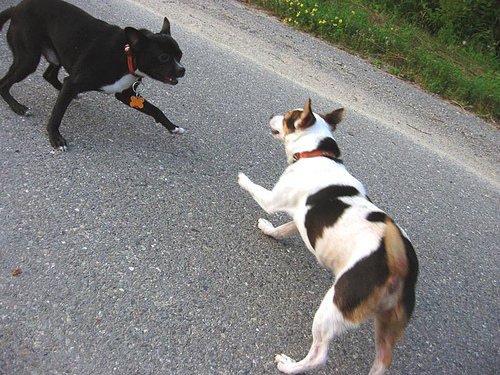

A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .


In [ ]:
# Now lets display an image and its caption.

temp = captions[8].split('#')
print(len(temp))
from IPython.display import Image, display

z = Image(filename = image_path+temp[0])
display(z)

for i in range(len(tokens[temp[0]])):
  print(tokens[temp[0]][i])

In [ ]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [ ]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in X_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in X_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in X_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

# Image Encoding

In [ ]:
from keras.preprocessing import image
import random
# from imagenet_utils import preprocess_input
import six.moves.cPickle as pickle
from keras.utils.data_utils import get_file
from keras import backend as K
from __future__ import absolute_import, division, print_function

In [ ]:
tf.random.set_seed(101)
random.seed(101)
np.random.seed(101)

In [ ]:
def load_ResNet():
  model = tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      input_shape=(224,224,3),
      pooling='avg'
  )
  #print(type(model))
  #model.summary()
  return model

def load_vgg():
  model = tf.keras.applications.VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))
  #model.summary()
  return model
# model = load_vgg()

In [ ]:
def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_data_format()
    # assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


In [ ]:
def encodings(model, path):
	processed_img = image.load_img(path, target_size=(224,224))
	x = image.img_to_array(processed_img)
	x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	image_final = np.asarray(x)
	prediction = model.predict(image_final).reshape(2048)
	# prediction = np.reshape(prediction, prediction.shape[1])

	return prediction

In [ ]:
def encode_image():
	model = load_ResNet()
	image_encodings = {}

	train_imgs_id = open('/content/sample_data/datasets/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt').read().split('\n')[:-1]
	print(len(train_imgs_id))
	test_imgs_id = open('/content/sample_data/datasets/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt').read().split('\n')[:-1]
	images = []
	images.extend(train_imgs_id)
	images.extend(test_imgs_id)
	print(len(images))
	bar = progressbar.ProgressBar(maxval=len(images), \
    		widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
	bar.start()
	counter=1
	print("Encoding images")

	for img in images:
		path = "/content/sample_data/datasets/flickr_data/Flickr_Data/Images/"+str(img)
		image_encodings[img] = encodings(model, path)
		bar.update(counter)
		counter += 1

	bar.finish()
	with open( "image_encodings.p", "wb" ) as pickle_f:
		pickle.dump( image_encodings, pickle_f )
	print("Encodings dumped into image_encodings.p")


In [ ]:
encode_image()

[                                                                        ] N/A%

<class 'keras.engine.functional.Functional'>
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________

[========================================================================] 100%


Encodings dumped into image_encodings.p


In [ ]:
import shutil
shutil.copy("/content/image_encodings_2048d.p","/content/gdrive/MyDrive/Datasets/Image Captioning/")


'/content/gdrive/MyDrive/Datasets/Image Captioning/image_encodings_2048d.p'

# Text Preprocessing

In [ ]:
# Loading image and its corresponding caption
dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [ ]:
ds = dataset.values
print(ds.shape)

(30000, 2)


So we have 30000 rows and 2 columns/features.

In [ ]:
for i in range(0,5):
  print(ds[i])

['2513260012_03d33305cf.jpg'
 '<start> A black dog is running after a white dog in the snow . <end>']
['2513260012_03d33305cf.jpg'
 '<start> Black dog chasing brown dog through snow <end>']
['2513260012_03d33305cf.jpg'
 '<start> Two dogs chase each other across the snowy ground . <end>']
['2513260012_03d33305cf.jpg'
 '<start> Two dogs play together in the snow . <end>']
['2513260012_03d33305cf.jpg'
 '<start> Two dogs running through a low lying body of water . <end>']


In [ ]:
# Lets grab all the captions from 'ds'
sentences = []
for i in range(ds.shape[0]): # ds.shape[0] is 30000
  sentences.append(ds[i,1])  # here 1 means we are grabing sentences only(0 for images name)
print(len(sentences))

30000


In [ ]:
# lets have a look at our sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [ ]:
# we gonna use a custom vocab for training purpose then we will use a pretrained word embedding
words = [i.split() for i in sentences]  # tokenization
vocab = []
for i in words:
  vocab.extend(i)
vocab = list(set(vocab))
vocab_size = len(vocab)
print(vocab_size)

8253


Now we have a vocabulary of 8253 words.

In [ ]:
# Now Lets vectorize our senteces
word_to_index = {val:ind for ind, val in enumerate(vocab)}
index_to_word = {ind:val for ind, val in enumerate(vocab)}

In [ ]:
word_to_index['UNK'] = 0
word_to_index['raining'] = 8253

In [ ]:
index_to_word[0] = 'UNK'
index_to_word[8253] = 'raining'

In [ ]:
vocab_size = len(word_to_index.keys())
print(vocab_size)

8254


In [ ]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


Here we have maximum sentence length of 40.

In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_to_index[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    print("next_words_1hot", next_words_1hot.shape)
    print("next_words", next_words)
    #Vectorization
    for i,next_word in enumerate(next_words):
        print("next_word", next_word)
        next_words_1hot[i, next_word] = 1

    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

In [ ]:
print(padded_sequences[0])

[[4280    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4280 4830    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4280 4830 6456    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4280 4830 6456 2538    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4280 4830 6456 2538 2208    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(index_to_word[padded_sequences[0][ix][iy]],)
    print("\n")
print(len(padded_sequences[0]))

In [ ]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [ ]:
# This will take a while. So load the file instead..
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [ ]:
shutil.copy('/content/next_words.npy','/content/drive/MyDrive/Datasets/Image Captioning/')

In [ ]:
shutil.copy('/content/captions.npy','/content/drive/MyDrive/Datasets/Image Captioning')

'/content/drive/MyDrive/Datasets/Image Captioning/captions.npy'

In [ ]:
# train_data = {}
# with open("/content/drive/MyDrive/Datasets/Image Captioning/image_encodings.p", 'rb') as pkl:
#   train_data = pickle.load(pkl)
# pkl_file.close()

In [ ]:
image_encodings = pkl.load( open( "/content/gdrive/MyDrive/Datasets/Image Captioning/image_encodings_2048d.p", "rb" ) , encoding="bytes")

In [ ]:
image_encodings.keys()

dict_keys(['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117_b4543e1460.jpg', '6971

In [ ]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in image_encodings.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(image_encodings[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(30000, 2048)


In [ ]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])

images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [ ]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])

image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [ ]:
shutil.copy("/content/images.npy","/content/gdrive/MyDrive/Datasets/Image Captioning")
shutil.copy("/content/image_names.npy","/content/gdrive/MyDrive/Datasets/Image Captioning")

'/content/gdrive/MyDrive/Datasets/Image Captioning/image_names.npy'

# Model

In [ ]:
# captions = np.load("/content/gdrive/MyDrive/Image Captioning/captions.npy")
# next_words = np.load("/content/gdrive/MyDrive/Image Captioning/next_words.npy")
# # images = np.load("/content/gdrive/MyDrive/Datasets/Image Captioning/images.npy")
# images = np.load("/content/images.npy")

# print(images.shape)
# print(captions.shape)
# print(next_words.shape)

embedding_size = 128
max_len = 40

Here we gonna have 2 models
* Image model
* Language Model

#### Image Model

In [ ]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


#### Language Model

In [ ]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

NameError: ignored

### Captioning Model

In [ ]:
concat = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(concat)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

In [ ]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

In [ ]:
model.save_weights("model_weights.h5")

In [ ]:
import shutil
shutil.copy("/content/model_weights.h5","/content/gdrive/MyDrive/Datasets/Image Captioning")

'/content/gdrive/MyDrive/Datasets/Image Captioning/model_weights.h5'

# Prediction Time

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def encodings(model, path):
	processed_img = image.load_img(path, target_size=(224,224))
	x = image.img_to_array(processed_img)
	x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	image_final = np.asarray(x)
	prediction = model.predict(image_final).reshape(2048)
	# prediction = np.reshape(prediction, prediction.shape[1])

	return prediction

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
ResNet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg'
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
img = "/content/sample_data/datasets/Flickr_Data/Flickr_Data/Images/1003163366_44323f5815.jpg"
test_img = encodings(ResNet, img)

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_to_index[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = index_to_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

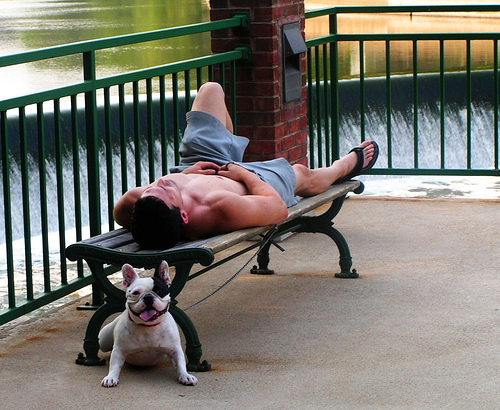

save darkness gettnig suited kids piercings darkness suited save kickflip syrup union piercings feild flanked Caribbean vessel vessel vessel vessel Caribbean vessel vessel vessel vessel vessel vessel vessel vessel Caribbean vessel vessel vessel vessel vessel vessel vessel vessel vessel


In [ ]:
z = Image(filename=img)
display(z)

print(Argmax_Search)